In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as pylab
from matplotlib import pyplot as plt
from scipy.special import lambertw
from sklearn.neighbors import NearestNeighbors

import sys
from os import path
current_folder = path.dirname(path.abspath('')); sys.path.append(current_folder)
from estimators import *

params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
def probability_inseparable_sphere(alpha,n):
    ''' 
    %probability_inseparable_sphere calculate theoretical probability for point
    %to be inseparable for dimension n
    %
    %Inputs:
    %   alpha is 1-by-d vector of possible alphas. Must be row vector or scalar
    %   n is c-by-1 vector of dimnesions. Must be column vector or scalar.
    %
    %Outputs:
    %   p is c-by-d matrix of probabilities.'''
    p = np.power((1-np.power(alpha,2)),(n-1)/2)/(alpha*np.sqrt(2*np.pi*n))
    return p

## Usual separability plots

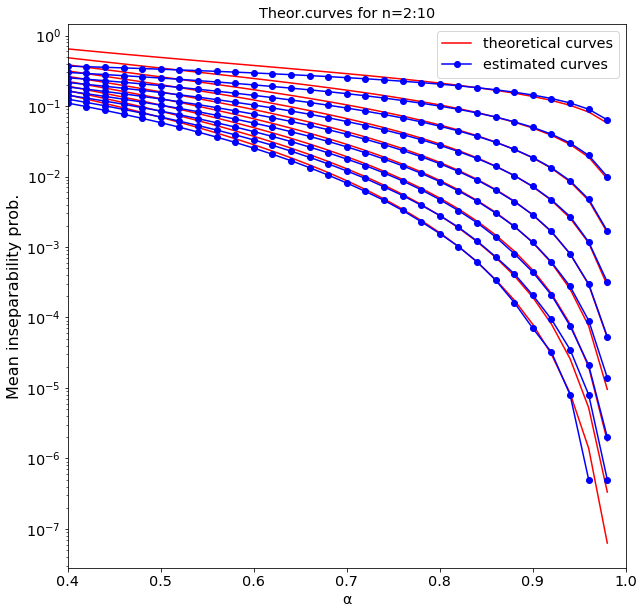

In [12]:
alphas = np.arange(.4,1,.02)[None]
ndims = np.arange(2,11)
plt.figure(figsize=(10,10))

for ndim in ndims:
    np.random.seed(0)
    data = randsphere(n_points=2000,ndim=ndim,radius=1)[0]
    n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=0,alphas=alphas)
    
    n_min = min(ndims)
    n_max = max(ndims)
    if n_min<1:
        n_min = 1

    ns = np.arange(n_min,n_max+1)
    
    py_mean = np.mean(p_alpha,axis=1)    
    #plt.xticks(locs,labels);
    pteor = np.zeros((len(ns),len(alphas[0,:])))
    for k in range(len(ns)):
        for j in range(len(alphas[0,:])):
            pteor[k,j] = probability_inseparable_sphere(alphas[0,j],ns[k])
            
    if ndim == ndims[0]:
        for i in range(len(pteor[:,0])):
            if ndim == ndims[0] and i==0:
                plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r',label='theoretical curves')
            else:
                plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r')
        plt.xlim(min(alphas[0,:]),1)
    
    if ndim == ndims[0]:
        if True in np.isnan(n_alpha):
                plt.semilogy(alphas[0,:np.where(np.isnan(n_alpha))[0][0]],py_mean[:np.where(np.isnan(n_alpha))[0][0]],'bo-')#label='estimated curves')
        else: 
            plt.semilogy(alphas[0,:],py_mean,'bo-',label='estimated curves')

        plt.xlabel('\u03B1'); plt.ylabel('Mean inseparability prob.',fontsize=16);
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))
        
    else:
        if True in np.isnan(n_alpha):
                plt.semilogy(alphas[0,:np.where(np.isnan(n_alpha))[0][0]],py_mean[:np.where(np.isnan(n_alpha))[0][0]],'bo-')
        else: 
            plt.semilogy(alphas[0,:],py_mean,'bo-');

        plt.xlabel('\u03B1'); plt.ylabel('Mean inseparability prob.',fontsize=16);
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))

plt.legend()
plt.show()

#plt.figure()
#for ndim in ndims:
#    np.random.seed(0)
#    data = randsphere(n_points=1000,ndim=ndim,radius=1)[0]
#    n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=0)
#    alpha_index = (n_alpha==n_single).tolist().index(True)
#    palpha_selected = p_alpha[alpha_index,:]
#    plt.hist(p_alpha[alpha_index,:][0],bins=20,alpha=.5)
#    plt.xlabel('inseparability prob.p for \u03B1=%2.2f'%(alphas[0,alpha_index]),fontsize=16); plt.ylabel('Number of values')
plt.show()

## Possibility to limit global maxdim to embedding dimension

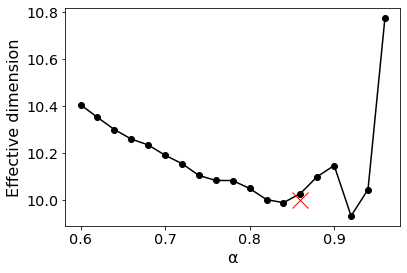

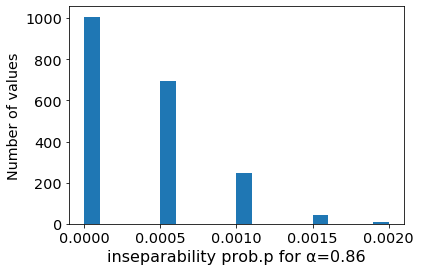

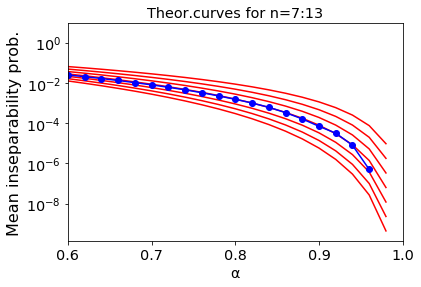

In [4]:
n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=1,limit_maxdim=True)

## Computing global pointwise ID + options

In [2]:
data = randsphere(n_points=20,ndim=3,radius=1)[0]

In [28]:
n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,
                                                                             ProducePlots=0,
                                                                             ncomp=1,
                                                                             ConditionalNumber=np.inf,
                                                                             alphas=np.arange(.2,1,.02)[None])

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]
palpha_selected

3 components are retained using factor inf


array([0.1 , 0.  , 0.05, 0.1 , 0.05, 0.05, 0.1 , 0.  , 0.05, 0.  , 0.05,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.05, 0.  , 0.05])

In [29]:
                                                                                  #other options:
                                                                                  #idx='all_inseparable'  
                                                                                  #idx= 5                  #force fully separable points to take value dim_separability(1/N)
n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected',         force_definite_dim=False)
print(n_pointwise,'\n')
n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected',         force_definite_dim=True)
print(n_pointwise)

11/20 points have nonzero inseparability probability for chosen alpha = 0.88, force_definite_dim = False
[2.43305769        nan 3.183533   2.43305769 3.183533   3.183533
 2.43305769        nan 3.183533          nan 3.183533          nan
        nan        nan        nan        nan 3.183533   3.183533
        nan 3.183533  ] 

20/20 points have nonzero inseparability probability for chosen alpha = 0.88, force_definite_dim = True
[2.43305769 3.183533   3.183533   2.43305769 3.183533   3.183533
 2.43305769 3.183533   3.183533   3.183533   3.183533   3.183533
 3.183533   3.183533   3.183533   3.183533   3.183533   3.183533
 3.183533   3.183533  ]


## What is the maximum dimension we can detect for a given cardinality and alpha ?

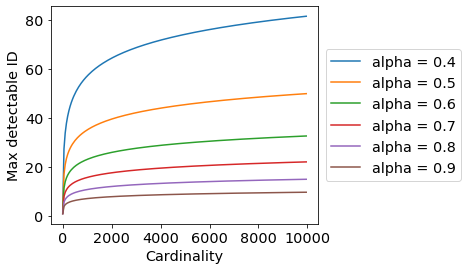

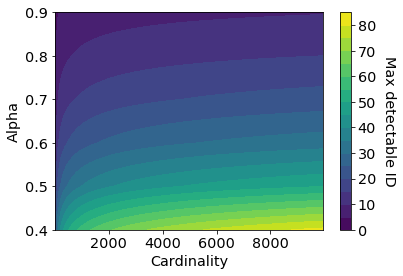

In [36]:
N=np.arange(2,10000,50)
alpha=np.arange(.4,1,.1)

alpha, N = np.meshgrid(alpha,N)

p  = 1/(N)
a2 = alpha**2
w = np.log(1-a2)
n = np.real(lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w))

#### Plotting
f = plt.figure()
ax = plt.subplot(111)
plt.xlabel('Cardinality')
plt.ylabel(f'Max detectable ID')#, alpha = {alpha}')
ax.plot(N,n)
#plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend([f'alpha = {round(a,2)}' for a in alpha[0]],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.xlabel('Cardinality')
plt.ylabel('Alpha')
cs = plt.contourf(N,alpha,n,16)
cb = plt.colorbar(); cb.ax.get_yaxis().labelpad = 20; cb.set_label('Max detectable ID', rotation=270)

#### Zooming in on small cardinalities

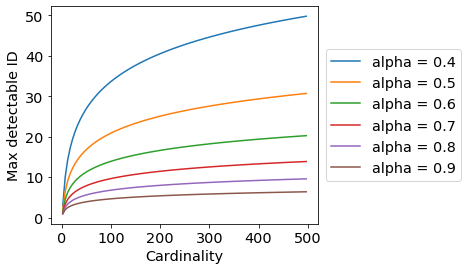

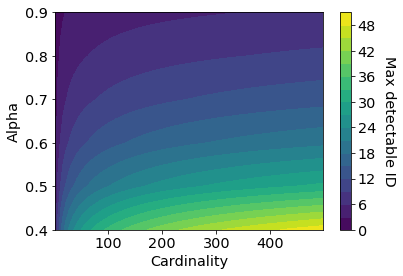

In [6]:
N=np.arange(2,500,5)
alpha=np.arange(.4,1,.1)

alpha, N = np.meshgrid(alpha,N)

p  = 1/(N)
a2 = alpha**2
w = np.log(1-a2)
n = np.real(lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w))

#### Plotting
f = plt.figure()
ax = plt.subplot(111)
plt.xlabel('Cardinality')
plt.ylabel(f'Max detectable ID')#, alpha = {alpha}')
ax.plot(N,n)
#plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend([f'alpha = {round(a,2)}' for a in alpha[0]],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.xlabel('Cardinality')
plt.ylabel('Alpha')
cs = plt.contourf(N,alpha,n,16)
cb = plt.colorbar(); cb.ax.get_yaxis().labelpad = 20; cb.set_label('Max detectable ID', rotation=270)

In [ ]:
f = plt.figure()
ax = plt.subplot(111)
plt.xlabel('Cardinality')
plt.ylabel(f'Max detectable ID')#, alpha = {alpha}')
ax.plot(N,n)
#plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend([f'alpha = {round(a,2)}' for a in alpha[0]],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.xlabel('Cardinality')
plt.ylabel('Alpha')
cs = plt.contourf(N,alpha,n,16)
cb = plt.colorbar(); cb.ax.get_yaxis().labelpad = 20; cb.set_label('Max detectable ID', rotation=270)

## 

## Computing kNN intrinsic dimension
From ESS paper:

"The procedure for finding a local data set is to choose a
point p from the whole data set and using its nearest
neighbors as the local data set. **The point p is not put into the local data set** since we want to assume that the local data is drawn from
a uniform distribution on a hyperball, and p will be in the center of
the hyperball, not drawn randomly."

### Testing robustness of local estimators to very high intrinsic dimension

In [3]:
data = randsphere(n_points=200,ndim=300,radius=1)[0] # mimic a local dataset

In [25]:
runANOVAglobal(data,k=200) # ANOVA underestimates a lot

array([[5]], dtype=uint8)

In [8]:
runDANCo(data) # FastDANCo can produce crazy numerical errors

array([1.9014759e+31])

In [14]:
danco_py(data,k=10,D=600,fractal=False)['de'] # regular DANCo overestimates

Computing DANCo calibration data for N = 200, k = 10 for dimensions 1 to 600


598

In [12]:
ess_py(data)[0] # ESS is very stable

299.70226084068355

In [16]:
twonn_py(data) # TwoNN underestimates

101.50736415801455

In [19]:
corint_py(data) # correlation dimension underestimates

array([59.99014242])

In [24]:
mada_py(data) # mada underestimates

71.2484664051803

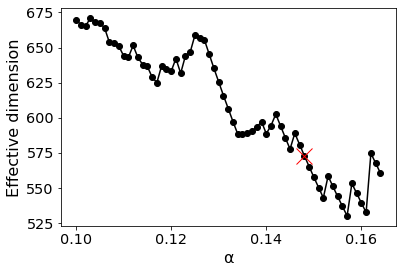

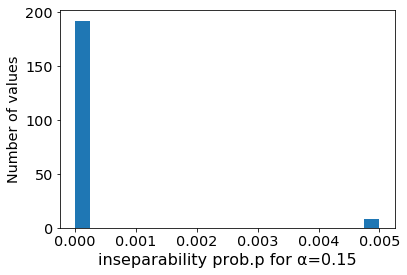

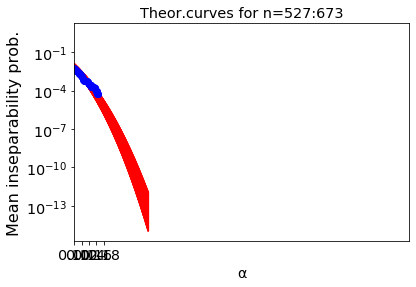

(array([669.79712185, 666.36876658, 665.32121985, 670.89672092,
        667.92503337, 667.75907132, 663.96876225, 653.80866663,
        653.2165078 , 650.95813103, 644.15245092, 642.97158832,
        651.46948004, 642.99147632, 637.91515607, 636.52982641,
        628.89670339, 624.98263592, 637.03846935, 634.74080986,
        633.03228444, 642.19560877, 631.65555014, 644.08206212,
        646.71953281, 658.81026574, 656.78596917, 655.4175408 ,
        645.15475269, 635.12970035, 625.33509699, 615.76393286,
        606.40946273, 597.26519399, 588.32487538, 588.23786104,
        588.91254559, 590.48796051, 593.1549961 , 597.18454798,
        588.62017347, 594.38999257, 602.5179272 , 594.05395884,
        585.76570156, 577.64832487, 588.87342822, 580.82118486,
        572.93160171, 565.20032665, 557.62315219, 550.19600967,
        542.91496383, 558.32572551, 551.03024396, 543.87549999,
        536.85789647, 529.97395045, 553.10031078, 546.09428992,
        539.21921116, 532.47183133, 574.

In [8]:
SeparabilityAnalysis(data,alphas=np.arange(.1,.3,.001)[None]) # separability overestimates 